In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd
from sklearn.model_selection import train_test_split

import os

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, \
                    Activation, BatchNormalization, ZeroPadding2D, Dropout
from keras.optimizers import Adam, SGD
import keras.backend as K

INPUT_FOLDER = "../input"
IMAGE_FOLDER = os.path.join(INPUT_FOLDER, "img_align_celeba", "img_align_celeba")
print(os.listdir(f"{INPUT_FOLDER}"))

['list_landmarks_align_celeba.csv', 'list_attr_celeba.csv', 'list_eval_partition.csv', 'list_bbox_celeba.csv', 'img_align_celeba']


In [25]:
# use 35000 out of 200000 as samples
num_samples = 35000
num_class = 10
lm_df = pd.read_csv(f"{INPUT_FOLDER}/list_landmarks_align_celeba.csv")[:num_samples]
img_orig_size = (178, 218)
img_width, img_height, img_channel = 60, 60, 3
x = np.zeros((num_samples, img_width, img_height, img_channel))
y = np.zeros((num_samples, num_class))
for i in range(len(lm_df)):
    row = lm_df.iloc[i]
    img = Image.open(f"{IMAGE_FOLDER}/" + row['image_id'])
    crop_width = (img_orig_size[0] - min(img_orig_size)) / 2
    crop_height = (img_orig_size[1] - min(img_orig_size)) / 2
    img = img.crop((crop_width, crop_height, img_orig_size[0] - crop_width, img_orig_size[1] - crop_height))
    img = img.resize((img_width, img_height))
    img_arr = np.array(img).reshape((img_width, img_height, img_channel)) / 255.0
    x[i] = img_arr
    y[i] = np.array([(row[j*2+1]-crop_width)/min(img_orig_size)*img_width for j in range(5)] + \
                    [(row[j*2+2]-crop_height)/min(img_orig_size)*img_height for j in range(5)])
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=10000, random_state=1337)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=1337)
print("training set: " + str((x_train.shape, y_train.shape)))
print("validation set: " + str((x_val.shape, y_val.shape)))
print("test set: " + str((x_test.shape, y_test.shape)))

training set: ((25000, 60, 60, 3), (25000, 10))
validation set: ((5000, 60, 60, 3), (5000, 10))
test set: ((5000, 60, 60, 3), (5000, 10))


The following architecture is based on Task-constrained Deep Convolutional Network (TCDCN) (Zhang et al, 2015)

In [26]:
lr = 8e-5
decay_rate = 1e-4

# input layer
input_img = Input(shape=(img_height, img_width, img_channel), name='input_img')

# layer 1
conv1 = Conv2D(20, kernel_size=(5, 5), activation='relu', name='conv1')(input_img)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

# layer 2
conv2 = Conv2D(48, kernel_size=(5, 5), activation='relu', name='conv2')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

# layer 3
conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv3')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

# layer 4
conv4 = Conv2D(80, kernel_size=(3, 3), activation='relu', name='conv4')(pool3)

# layer 5
flat = Flatten(name='flat')(conv4)

# landmark detection specific layer
drop1 = Dropout(0.1, name='drop1')(flat)
fc1 = Dense(256, activation='relu', name='fc1')(drop1)
drop2 = Dropout(0.1, name='drop2')(fc1)
out = Dense(num_class, activation='linear', name='out_landmarks')(drop2)

model = Model(inputs=input_img, outputs=out)
opt = Adam(lr=lr, decay=decay_rate)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 60, 60, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 56, 56, 20)        1520      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 20)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 48)        24048     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 12, 48)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 10, 10, 64)        27712     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 5, 5, 64)          0         
__________

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 153us/step - loss: 322.5707 - val_loss: 18.9551
Epoch 2/20
25000/25000 [==============================] - 3s 122us/step - loss: 26.9585 - val_loss: 12.8104
Epoch 3/20
25000/25000 [==============================] - 3s 121us/step - loss: 21.5935 - val_loss: 10.2075
Epoch 4/20
25000/25000 [==============================] - 3s 123us/step - loss: 17.4018 - val_loss: 6.3528
Epoch 5/20
25000/25000 [==============================] - 3s 123us/step - loss: 11.8768 - val_loss: 2.8528
Epoch 6/20
25000/25000 [==============================] - 3s 122us/step - loss: 8.8853 - val_loss: 1.6647
Epoch 7/20
25000/25000 [==============================] - 3s 122us/step - loss: 8.0280 - val_loss: 1.4495
Epoch 8/20
25000/25000 [==============================] - 3s 122us/step - loss: 7.6167 - val_loss: 1.4124
Epoch 9/20
25000/25000 [==============================] - 3s 124us/step - loss: 7.2219 - val_l

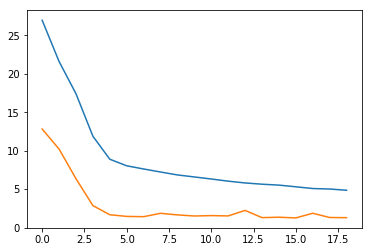

In [27]:
batch_size = 128
epochs = 20

history = model.fit(
    x_train,
    y_train, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_data=(x_val, y_val)
)

_ = plt.plot(history.history['loss'][1:])
_ = plt.plot(history.history['val_loss'][1:])

In [28]:
model.evaluate(x_test, y_test)

5000/5000 [==============================] - 1s 126us/step


1.269320841407776

Show examples of prediction on the test set. Green circle is the actual location and red cross is the predicted coordinates.

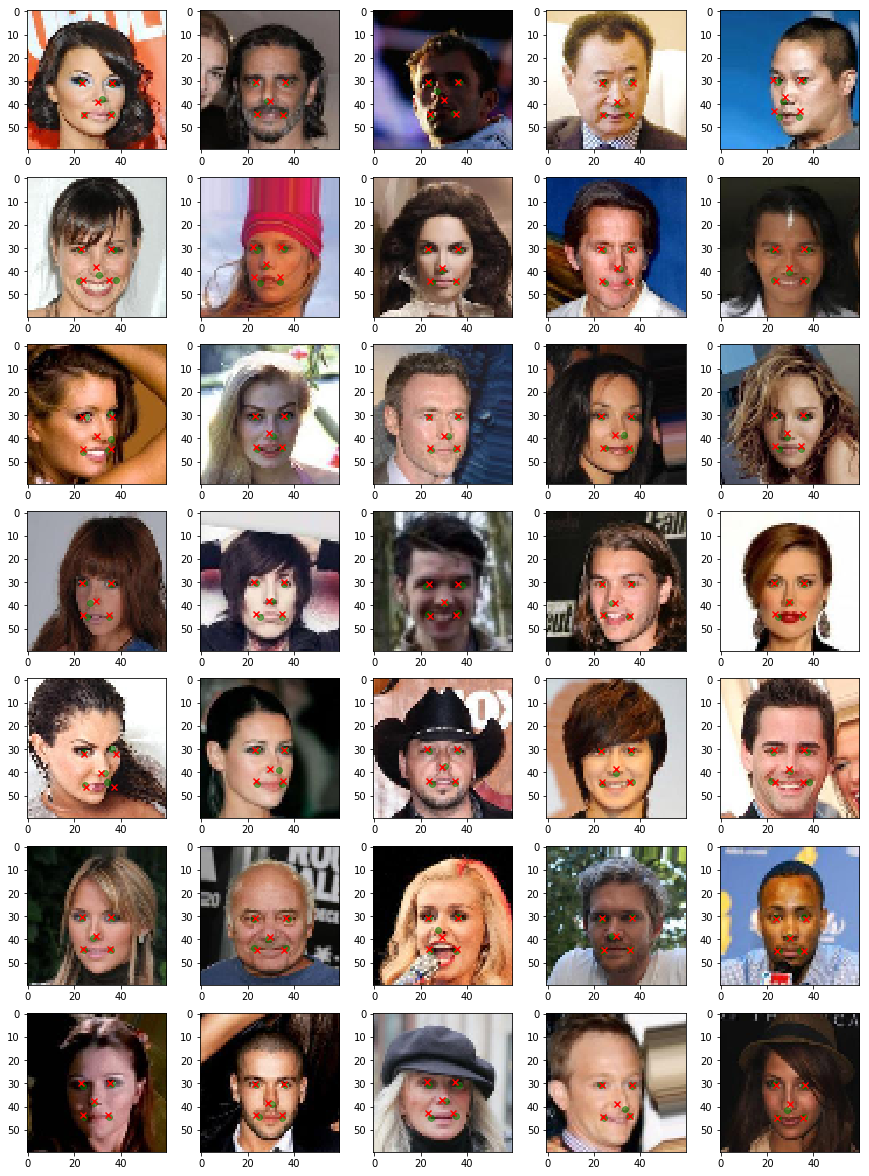

In [29]:
y_pred = model.predict(x_test)
fig=plt.figure(figsize=(15, 21))
columns = 5
rows = 7
for i in range(0, columns*rows):
    r = np.random.randint(len(x_test))
    fig.add_subplot(rows, columns, i+1)
    _ = plt.imshow(x_test[r])
    _ = plt.scatter([y_test[r,j] for j in range(5)], [y_test[r,5+j] for j in range(5)], c='green', alpha=0.5)
    _ = plt.scatter([y_pred[r,j] for j in range(5)], [y_pred[r,5+j] for j in range(5)], c='red', marker='x')
plt.show()

Not bad for a simple network and 60x60 image. Now let's calculate the error rate normalized by inter-ocular distance as an evaluation metric. If the error rate exceed $0.1$, the prediction is considered as failed.

In [30]:
def calculate_error_norm(y_true, y_pred):
    result = np.zeros((y_true.shape[0], 5))
    ioc = np.sqrt(np.square(y_true[:,0] - y_true[:,1]) + np.square(y_true[:,5] - y_true[:,6]))
    for i in range(5):
        result[:, i] = np.sqrt(np.square(y_true[:,i] - y_pred[:,i]) + np.square(y_true[:,i+5] - y_pred[:,i+5])) / ioc
    return result

error_norm = calculate_error_norm(y_test, y_pred)
mean_error_norm = np.mean(error_norm) * 100
success_rate = (np.sum(error_norm < 0.1) / error_norm.size) * 100
print("mean test error rate={:.2f}%, success_rate={:.2f}%".format(mean_error_norm, success_rate))

mean test error rate=10.19%, success_rate=62.54%


- Next step: hyper-parameter tuning.
- Potential expansion: multi-task learning.

# References
- Zhang, Z., Luo, P., Loy, C. C., & Tang, X. (2015). Learning deep representation for face alignment with auxiliary attributes. IEEE transactions on pattern analysis and machine intelligence, 38(5), 918-930.